In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os.path


class ImageDataset(Dataset):
    def __init__(self, df, load_dir, transform):
        self.df = df
        self.load_dir = load_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.load_dir + "/Data/" + self.df.iloc[index,0]
        image = Image.open(image_path)
        tensor_image = self.transform(image)
        label = self.df.iloc[index,1]
        return tensor_image, label


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) # input, output, kernal size 
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*116*116, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dp1 = nn.Dropout(0.5)
        self.dp2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = x.view(-1, 32*116*116)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        # x = F.log_softmax(x, dim=1)
        return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_workers = 12
num_epoch = 10
batch_size = 128
learning_rate = 0.001


load_dir = "/content/drive/MyDrive/Projects/wikiart"
#load_dir = "/content/drive/.shortcut-targets-by-id/162Kf_zOQOfxR3jWEwQzxFxYLZbKOqb4S/WikiArt"
df_train = pd.read_csv(load_dir+'/Labels/Genre/genre_train.csv')
df_val = pd.read_csv(load_dir+'/Labels/Genre/genre_val.csv')
transform = transforms.Compose([transforms.Resize((240, 240)),
                                transforms.ToTensor(),])
data_train = ImageDataset(df_train, load_dir, transform)
data_val = ImageDataset(df_val, load_dir, transform)
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)


model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store accuracy values
train_acc_list = []
val_acc_list = []


for epoch in range(num_epoch):
    batch_accuracies = []
    for batch_idx, (images, labels) in enumerate(tqdm(dataloader_train)):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0) * 100
        train_acc_list.append(accuracy)
        batch_accuracies.append(accuracy)
    
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for images, labels in dataloader_val:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    val_accuracy = total_correct / total_samples * 100
    val_acc_list.append(val_accuracy)
    for count, accuracy in enumerate(batch_accuracies):
        if count % int(len(dataloader_train)/10) == 0:
            print(f"Epoch [{epoch+1}/{num_epoch}], Batch [{count}/{len(dataloader_train)}], Train Accuracy: {accuracy:.2f}%")
    print(f"Epoch [{epoch+1}/{num_epoch}], Validation Accuracy: {val_accuracy:.2f}%")
    model.train()

 89%|████████▉ | 317/356 [19:22<01:40,  2.57s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 94%|█████████▍| 335/356 [20:37<00:46,  2.20s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [21:47<00:00,  3.67s/it]


Epoch [1/10], Batch [0/356], Train Accuracy: 7.03%
Epoch [1/10], Batch [35/356], Train Accuracy: 29.69%
Epoch [1/10], Batch [70/356], Train Accuracy: 32.03%
Epoch [1/10], Batch [105/356], Train Accuracy: 32.81%
Epoch [1/10], Batch [140/356], Train Accuracy: 34.38%
Epoch [1/10], Batch [175/356], Train Accuracy: 32.03%
Epoch [1/10], Batch [210/356], Train Accuracy: 47.66%
Epoch [1/10], Batch [245/356], Train Accuracy: 36.72%
Epoch [1/10], Batch [280/356], Train Accuracy: 35.94%
Epoch [1/10], Batch [315/356], Train Accuracy: 39.06%
Epoch [1/10], Batch [350/356], Train Accuracy: 38.28%
Epoch [1/10], Validation Accuracy: 42.30%


 37%|███▋      | 132/356 [01:12<00:38,  5.85it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 47%|████▋     | 169/356 [01:34<02:11,  1.42it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [03:09<00:00,  1.88it/s]


Epoch [2/10], Batch [0/356], Train Accuracy: 38.28%
Epoch [2/10], Batch [35/356], Train Accuracy: 40.62%
Epoch [2/10], Batch [70/356], Train Accuracy: 43.75%
Epoch [2/10], Batch [105/356], Train Accuracy: 50.00%
Epoch [2/10], Batch [140/356], Train Accuracy: 48.44%
Epoch [2/10], Batch [175/356], Train Accuracy: 36.72%
Epoch [2/10], Batch [210/356], Train Accuracy: 40.62%
Epoch [2/10], Batch [245/356], Train Accuracy: 53.12%
Epoch [2/10], Batch [280/356], Train Accuracy: 41.41%
Epoch [2/10], Batch [315/356], Train Accuracy: 45.31%
Epoch [2/10], Batch [350/356], Train Accuracy: 40.62%
Epoch [2/10], Validation Accuracy: 47.23%


 61%|██████    | 216/356 [01:55<00:29,  4.73it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 93%|█████████▎| 332/356 [02:59<00:06,  3.85it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [03:10<00:00,  1.87it/s]


Epoch [3/10], Batch [0/356], Train Accuracy: 47.66%
Epoch [3/10], Batch [35/356], Train Accuracy: 48.44%
Epoch [3/10], Batch [70/356], Train Accuracy: 46.88%
Epoch [3/10], Batch [105/356], Train Accuracy: 53.12%
Epoch [3/10], Batch [140/356], Train Accuracy: 52.34%
Epoch [3/10], Batch [175/356], Train Accuracy: 54.69%
Epoch [3/10], Batch [210/356], Train Accuracy: 54.69%
Epoch [3/10], Batch [245/356], Train Accuracy: 47.66%
Epoch [3/10], Batch [280/356], Train Accuracy: 49.22%
Epoch [3/10], Batch [315/356], Train Accuracy: 46.88%
Epoch [3/10], Batch [350/356], Train Accuracy: 49.22%
Epoch [3/10], Validation Accuracy: 49.28%


  3%|▎         | 11/356 [00:08<01:16,  4.54it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 67%|██████▋   | 239/356 [02:08<00:20,  5.57it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [03:08<00:00,  1.89it/s]


Epoch [4/10], Batch [0/356], Train Accuracy: 48.44%
Epoch [4/10], Batch [35/356], Train Accuracy: 52.34%
Epoch [4/10], Batch [70/356], Train Accuracy: 56.25%
Epoch [4/10], Batch [105/356], Train Accuracy: 55.47%
Epoch [4/10], Batch [140/356], Train Accuracy: 52.34%
Epoch [4/10], Batch [175/356], Train Accuracy: 64.06%
Epoch [4/10], Batch [210/356], Train Accuracy: 54.69%
Epoch [4/10], Batch [245/356], Train Accuracy: 51.56%
Epoch [4/10], Batch [280/356], Train Accuracy: 55.47%
Epoch [4/10], Batch [315/356], Train Accuracy: 60.94%
Epoch [4/10], Batch [350/356], Train Accuracy: 56.25%
Epoch [4/10], Validation Accuracy: 50.16%


 50%|████▉     | 177/356 [01:39<00:52,  3.43it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 63%|██████▎   | 224/356 [02:05<00:50,  2.62it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [03:10<00:00,  1.86it/s]


Epoch [5/10], Batch [0/356], Train Accuracy: 62.50%
Epoch [5/10], Batch [35/356], Train Accuracy: 70.31%
Epoch [5/10], Batch [70/356], Train Accuracy: 67.19%
Epoch [5/10], Batch [105/356], Train Accuracy: 60.16%
Epoch [5/10], Batch [140/356], Train Accuracy: 67.19%
Epoch [5/10], Batch [175/356], Train Accuracy: 59.38%
Epoch [5/10], Batch [210/356], Train Accuracy: 67.19%
Epoch [5/10], Batch [245/356], Train Accuracy: 60.16%
Epoch [5/10], Batch [280/356], Train Accuracy: 60.94%
Epoch [5/10], Batch [315/356], Train Accuracy: 63.28%
Epoch [5/10], Batch [350/356], Train Accuracy: 67.19%
Epoch [5/10], Validation Accuracy: 50.35%


 17%|█▋        | 61/356 [00:39<06:56,  1.41s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 37%|███▋      | 132/356 [01:14<00:45,  4.96it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [03:11<00:00,  1.86it/s]


Epoch [6/10], Batch [0/356], Train Accuracy: 60.94%
Epoch [6/10], Batch [35/356], Train Accuracy: 69.53%
Epoch [6/10], Batch [70/356], Train Accuracy: 69.53%
Epoch [6/10], Batch [105/356], Train Accuracy: 71.09%
Epoch [6/10], Batch [140/356], Train Accuracy: 64.06%
Epoch [6/10], Batch [175/356], Train Accuracy: 73.44%
Epoch [6/10], Batch [210/356], Train Accuracy: 67.97%
Epoch [6/10], Batch [245/356], Train Accuracy: 64.06%
Epoch [6/10], Batch [280/356], Train Accuracy: 68.75%
Epoch [6/10], Batch [315/356], Train Accuracy: 73.44%
Epoch [6/10], Batch [350/356], Train Accuracy: 75.00%
Epoch [6/10], Validation Accuracy: 50.27%


  8%|▊         | 27/356 [00:19<04:10,  1.32it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 38%|███▊      | 135/356 [01:14<01:27,  2.53it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [03:08<00:00,  1.89it/s]


Epoch [7/10], Batch [0/356], Train Accuracy: 72.66%
Epoch [7/10], Batch [35/356], Train Accuracy: 82.81%
Epoch [7/10], Batch [70/356], Train Accuracy: 73.44%
Epoch [7/10], Batch [105/356], Train Accuracy: 75.00%
Epoch [7/10], Batch [140/356], Train Accuracy: 72.66%
Epoch [7/10], Batch [175/356], Train Accuracy: 69.53%
Epoch [7/10], Batch [210/356], Train Accuracy: 67.19%
Epoch [7/10], Batch [245/356], Train Accuracy: 75.78%
Epoch [7/10], Batch [280/356], Train Accuracy: 76.56%
Epoch [7/10], Batch [315/356], Train Accuracy: 71.09%
Epoch [7/10], Batch [350/356], Train Accuracy: 71.09%
Epoch [7/10], Validation Accuracy: 49.72%


  0%|          | 0/356 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 64%|██████▍   | 229/356 [02:04<00:19,  6.49it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [03:09<00:00,  1.88it/s]


Epoch [8/10], Batch [0/356], Train Accuracy: 69.53%
Epoch [8/10], Batch [35/356], Train Accuracy: 77.34%
Epoch [8/10], Batch [70/356], Train Accuracy: 83.59%
Epoch [8/10], Batch [105/356], Train Accuracy: 75.78%
Epoch [8/10], Batch [140/356], Train Accuracy: 83.59%
Epoch [8/10], Batch [175/356], Train Accuracy: 80.47%
Epoch [8/10], Batch [210/356], Train Accuracy: 78.12%
Epoch [8/10], Batch [245/356], Train Accuracy: 75.78%
Epoch [8/10], Batch [280/356], Train Accuracy: 78.91%
Epoch [8/10], Batch [315/356], Train Accuracy: 78.91%
Epoch [8/10], Batch [350/356], Train Accuracy: 82.81%
Epoch [8/10], Validation Accuracy: 48.96%


  7%|▋         | 24/356 [00:15<01:08,  4.86it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 22%|██▏       | 78/356 [00:47<01:59,  2.33it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [03:08<00:00,  1.89it/s]


Epoch [9/10], Batch [0/356], Train Accuracy: 84.38%
Epoch [9/10], Batch [35/356], Train Accuracy: 80.47%
Epoch [9/10], Batch [70/356], Train Accuracy: 81.25%
Epoch [9/10], Batch [105/356], Train Accuracy: 78.91%
Epoch [9/10], Batch [140/356], Train Accuracy: 79.69%
Epoch [9/10], Batch [175/356], Train Accuracy: 83.59%
Epoch [9/10], Batch [210/356], Train Accuracy: 84.38%
Epoch [9/10], Batch [245/356], Train Accuracy: 81.25%
Epoch [9/10], Batch [280/356], Train Accuracy: 75.78%
Epoch [9/10], Batch [315/356], Train Accuracy: 74.22%
Epoch [9/10], Batch [350/356], Train Accuracy: 74.22%
Epoch [9/10], Validation Accuracy: 49.49%


 72%|███████▏  | 255/356 [02:18<00:47,  2.15it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 96%|█████████▌| 341/356 [03:02<00:08,  1.87it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 356/356 [03:07<00:00,  1.90it/s]


Epoch [10/10], Batch [0/356], Train Accuracy: 85.16%
Epoch [10/10], Batch [35/356], Train Accuracy: 86.72%
Epoch [10/10], Batch [70/356], Train Accuracy: 82.03%
Epoch [10/10], Batch [105/356], Train Accuracy: 82.03%
Epoch [10/10], Batch [140/356], Train Accuracy: 82.03%
Epoch [10/10], Batch [175/356], Train Accuracy: 81.25%
Epoch [10/10], Batch [210/356], Train Accuracy: 80.47%
Epoch [10/10], Batch [245/356], Train Accuracy: 83.59%
Epoch [10/10], Batch [280/356], Train Accuracy: 77.34%
Epoch [10/10], Batch [315/356], Train Accuracy: 83.59%
Epoch [10/10], Batch [350/356], Train Accuracy: 81.25%
Epoch [10/10], Validation Accuracy: 49.63%


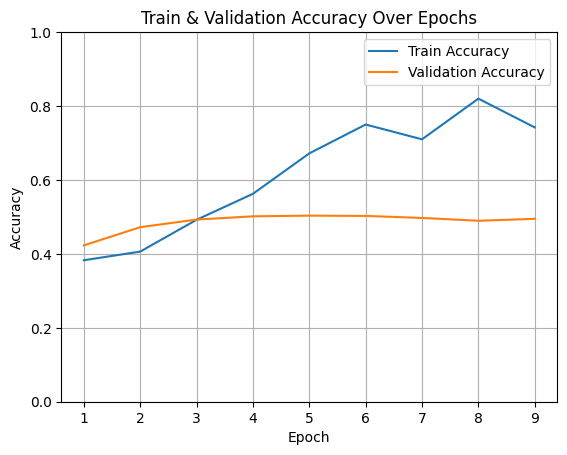

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = [0.3828, 0.4062, 0.4922, 0.5625, 0.6719, 0.75, 0.71, 0.82, 0.7422]
validation_accuracy = [0.423, 0.4723, 0.4928, 0.5016, 0.5035, 0.5027, 0.4972, 0.4896, 0.4949]
epochs = range(1, 10)

plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

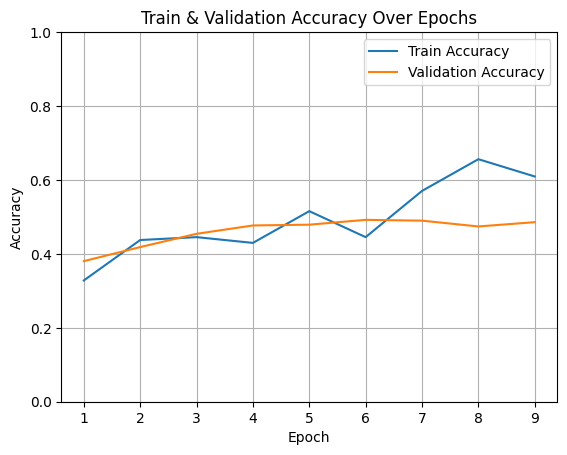

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = [0.3281, 0.4375, 0.4453, 0.4297, 0.5156, 0.4453, 0.5703, 0.6562, 0.6094]
validation_accuracy = [0.3804, 0.4184, 0.4543, 0.4769, 0.4790, 0.4921, 0.4899, 0.4742, 0.4858]
epochs = range(1, 10)

plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()